# **LightGBM**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import joblib
import lightgbm as lgb
import preprocessing as pp

warnings.filterwarnings('ignore')

# Obtenemos los dataframes con los que trabajaremos

In [3]:
X, y = pp.get_X_y_from_dataset()

Hay un problema... la variable target "llovieron_hamburguesas_al_dia_siguiente" contiene NaNs (~2600). Esto es un problema a la hora de separar en train-valdev-holdout usando train_test_split si queremos preservar la proporción entre las clases del target en la partición (es decir, pasandole a esa función stratify=y). Como test-holdout nunca debe ver los datos de train o valdev, no deberíamos rellenar dichos NaNs usando datos de otras instancias (si no habría data leaks). Por ende, decidimos completar estos NaNs con la clase mayoritaria por lejos, el "no". 

In [4]:
y = pp.fill_nan_with_simple_imputer(y, ["llovieron_hamburguesas_al_dia_siguiente"], "most_frequent")

También no necesitamos la columna de id.

In [5]:
pp.drop_features(y, ['id']) 

## Separamos en train y test-holdout
Test-holdout lo usaremos como métrica del mejor de los 5 modelos, para tener una idea antes que salga a producción. Tomaremos un 10% para el holdout, y hacemos que sea stratificado, de forma que divida el train y holdout teniendo en cuenta la proporción de la variable target. Notar que usamos el mismo RANDOM_STATE para todos los train_test_splits de los modelos para poder reproducir las mismas condiciones, entrenando y evaluando sobre las mismas particiones.

In [6]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, random_state=pp.RANDOM_STATE, test_size=0.1, stratify=y
)

# Preprocesamiento y Feature Engineering

A diferencia de las implementaciones de SKLearn, el LightGBM de esta librería no necesita tener una variable target numérica. Por eso no la encodeamos. Esto tiene sentido porque utiliza árboles de decisión por dentro, los cuales vimos en la teoría que a priori no necesitan que estén encodeadas las variables categóricas.

## Corregimos los valores erraticos del dataset

El feature presión_atmosférica_tarde tiene algunos valores erráticos. Los eliminamos y dejamos temporalmente como NaN, de forma de rellenarlos (o no) a posteriori.

In [7]:
err_values_presion_atm = ['10.167.769.999.999.900', '1.009.555']

pp.convert_values_to_nan(X_train, 'presion_atmosferica_tarde', err_values_presion_atm)

Ahora sí, podemos convertir este feature de object a float.

In [8]:
X_train = pp.convert_features(X_train, ['presion_atmosferica_tarde'], 'float32')

Y ahora corregimos los valores erráticos de la nubosidad_tarde y nubosidad_temprano:

In [9]:
err_values_nubosidad = [9.0]

pp.convert_values_to_nan(X_train, 'nubosidad_tarde', err_values_nubosidad)
pp.convert_values_to_nan(X_train, 'nubosidad_temprano', err_values_nubosidad)

## Selección #1: Descartemos features irrelevantes
De acuerdo con la primera parte del TP, tenemos una idea de cuáles features son relevantes y cuales parecen ser completamente irrelevantes para la tarea de predecir si lloverá al día siguiente o no. Descartaremos algunos de los más irrelevantes.

In [10]:
pp.drop_features(X_train, 
              ['barrio',
             'humedad_temprano',
             'temp_min',
             'rafaga_viento_max_direccion',
             'velocidad_viendo_tarde',
             'velocidad_viendo_temprano',
             'rafaga_viento_max_velocidad'])

## Convertimos los dias a Datetime

In [11]:
X_train = pp.convert_features(X_train, ['dia'], 'datetime64')

Ahora extraemos el mes del feature 'dia', para trabajar con estos.

In [12]:
X_train = pp.extract_month_from_date(X_train)

Eliminamos el feature Dia, ya que vamos a trabajar con los meses.

In [13]:
pp.drop_features(X_train, ['dia'])

## Escalar las variables numericas

Escalamos las variables numericas para que esten todas dentro de un mismo parametro.

In [14]:
features_to_scale = ['horas_de_sol','humedad_tarde', 'mm_evaporados_agua', 
                     'mm_lluvia_dia', 'presion_atmosferica_temprano', 'presion_atmosferica_tarde', 
                     'temp_max', 'temperatura_tarde', 
                     'temperatura_temprano','mes']

X_train = pp.standard_scale(X_train, features_to_scale)
X_train.head()

,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,temp_max,temperatura_tarde,temperatura_temprano,mes
32489,Norte,Nornoreste,NaN,-2.192918,144830,no,NaN,-0.280907,NaN,NaN,-0.221242,0.372084,1.541459,1.631562,1.385308,1.048131
83946,Sureste,Sursureste,-0.904636,1.228314,87711,no,-0.690600,-0.280907,7.0,5.0,-0.235449,-0.260813,1.035333,0.895409,1.708862,-0.702364
21588,Sur,Estesureste,0.099665,-1.229190,136988,no,-0.353998,-0.280907,5.0,2.0,0.503062,0.498666,-0.131569,-0.172735,-1.110675,0.172883
20436,Oestesuroeste,Oeste,-0.772491,0.794636,99850,si,0.126863,-0.042663,7.0,7.0,0.219020,-0.724935,-0.961053,-1.038798,-0.586826,1.339880
105562,Oeste,Estesureste,0.707531,-1.132818,80032,no,-0.353998,-0.280907,7.0,4.0,0.829709,1.159694,0.219907,0.072650,-0.633048,1.339880


## Aplicamos One Hot encoding a las variables categóricas no ordinales

In [15]:
X_train = pp.one_hot_encode(X_train, 
    ['direccion_viento_tarde',
     'direccion_viento_temprano', 
     'llovieron_hamburguesas_hoy'])

X_train.head()

,horas_de_sol,humedad_tarde,id,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,temp_max,...,direccion_viento_temprano_Oestenoroeste,direccion_viento_temprano_Oestesuroeste,direccion_viento_temprano_Sur,direccion_viento_temprano_Sureste,direccion_viento_temprano_Sursureste,direccion_viento_temprano_Sursuroeste,direccion_viento_temprano_suroeste,direccion_viento_temprano_nan,llovieron_hamburguesas_hoy_si,llovieron_hamburguesas_hoy_nan
32489,NaN,-2.192918,144830,NaN,-0.280907,NaN,NaN,-0.221242,0.372084,1.541459,...,0,0,0,0,0,0,0,0,0,0
83946,-0.904636,1.228314,87711,-0.690600,-0.280907,7.0,5.0,-0.235449,-0.260813,1.035333,...,0,0,0,0,1,0,0,0,0,0
21588,0.099665,-1.229190,136988,-0.353998,-0.280907,5.0,2.0,0.503062,0.498666,-0.131569,...,0,0,0,0,0,0,0,0,0,0
20436,-0.772491,0.794636,99850,0.126863,-0.042663,7.0,7.0,0.219020,-0.724935,-0.961053,...,0,0,0,0,0,0,0,0,1,0
105562,0.707531,-1.132818,80032,-0.353998,-0.280907,7.0,4.0,0.829709,1.159694,0.219907,...,0,0,0,0,0,0,0,0,0,0


## Eliminemos los valores NaN completando con el mas frequente

Realizamos este paso para tener el dataset lo mas completo posible y así poder trabajar con mas datos.

In [16]:
X_train = pp.fill_nan_with_simple_imputer(X_train, X_train.columns, "most_frequent")

## Selección #2: utilizamos ML para filtrar
De los features que tenemos, seleccionaremos como mínimo los 20 más importantes según Recursive Feature Eliminator con Cross Validation de 3 folds, usando un árbol de decisión como estimador.

In [17]:
X_train, eliminated_features = pp.select_features_RFECV(X_train, y_train, 20)

Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 fe

## Separamos en train y val-dev

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train, 
                                                    test_size = 0.3, 
                                                    random_state = pp.RANDOM_STATE, 
                                                    stratify=y_train)

# Busco los mejores hiperparametros

Utilizamos GS para iterar entre todos los parametros y CV de 5 folds para obtener el mejor resultado por sobre varios testeos.

Determinamos 
#### subsample -> [0.8, 0.4, 0.1]
#### max_depth -> [10, 20, 15] 
#### learning_rate -> [0.001, 0.01, 0.05, 0.1, 0.15]

In [19]:
%%script false --no-raise-error # Para no ejecutar este bloque
params = {'subsample': [0.8, 0.4, 0.1], 'max_depth': [10, 20, 15], 'learning_rate': [0.1, 0.15, 0.20, 0.50]}

clf = lgb.LGBMClassifier(random_state=117)

gscv = GridSearchCV(
    clf, params, scoring='f1_micro', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

joblib.dump(gscv.best_estimator_, open("gridsearch_results/best_models/best_model_LightGBM.pickle", "wb"))

Una vez almacenado (en un .pickle) el mejor modelo la vez que se corrió el GridSearch, lo podemos utilizar en cualquier otro momento sin necesidad de correr el GridSearch de vuelta.

# Cargamos el modelo ya con los mejores hiperparámetros y lo entrenamos
Carguemos el mejor modelo. Lo entrenaremos pero en el X_train completo, para luego evaluarlo en X_test.

In [20]:
clf = joblib.load("gridsearch_results/best_models/best_model_LightGBM.pickle")
clf

LGBMClassifier(learning_rate=0.15, max_depth=20, random_state=117,
               subsample=0.8)

In [21]:
clf.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.15, max_depth=20, random_state=117,
               subsample=0.8)

# Evaluamos en val-dev y medimos la performance

### F1, Precision, Recall, Accuracy

In [22]:
clf_pred = clf.predict(X_test)

In [23]:
f1_score(y_test, clf_pred, average='weighted')

0.8413554395714145

In [24]:
precision_score(y_test, clf_pred, average='weighted')

0.8422686408471349

In [25]:
recall_score(y_test, clf_pred, average = 'weighted')

0.8517186505410567

In [26]:
accuracy_score(y_test, clf_pred)

0.8517186505410567

### Confusion Matrix

In [27]:
clf_pred_proba = clf.predict_proba(X_test)
clf_pred_proba_pos = clf_pred_proba[:,1] 

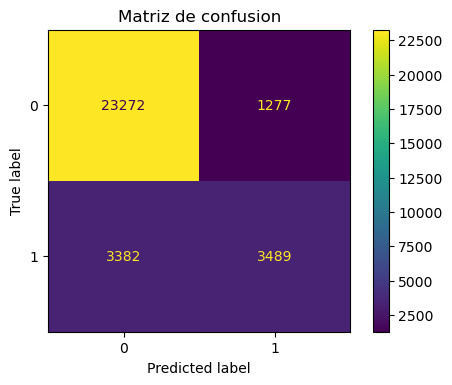

In [28]:
cm = confusion_matrix(y_test, clf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(dpi=100)
plt.title("Matriz de confusion")
disp.plot(ax=ax)

### AUC-ROC

In [29]:
def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(12, 8))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})'
    )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

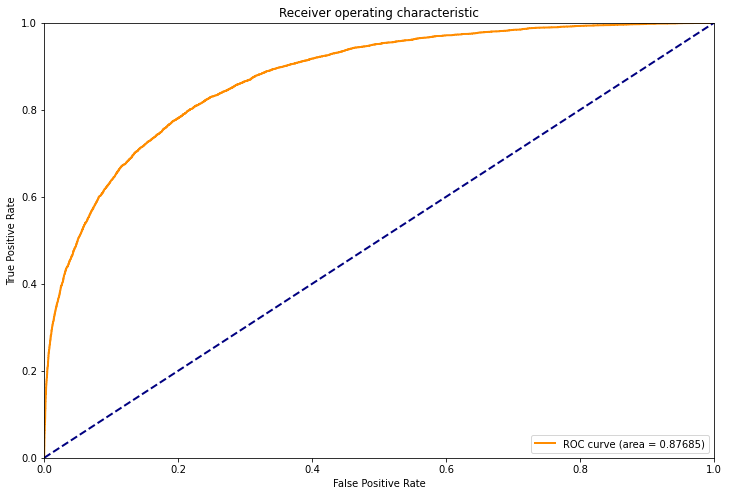

AUC_ROC:  0.8768545142346388


In [30]:
y_binary = pp.one_hot_encode(y_test, ['llovieron_hamburguesas_al_dia_siguiente'])
pp.drop_features(y_binary, ['llovieron_hamburguesas_al_dia_siguiente_nan'])
fpr, tpr, thresholds = roc_curve(y_binary, clf_pred_proba_pos)
plot_roc(fpr, tpr, thresholds)
print("AUC_ROC: ", roc_auc_score(y_binary, clf_pred_proba_pos))

# Predicción sobre los datos privados de Flint

Primero, hacemos el preprocesamiento de los datos, utilizando el mismo feature engineering que realizamos antes, para que el modelo pueda entender los datos que le pasamos. Luego, predecimos usando el modelo ya entrenado y finalmente guardamos los resultados.

In [31]:
X_private = pp.get_X_private_features()

In [32]:
def preprocess_X_for_LightGBM(X):
    X_train = pp.convert_features(X, ['presion_atmosferica_tarde'], 'float32')
    
    pp.drop_features(X, 
              ['barrio',
             'humedad_temprano',
             'temp_min',
             'rafaga_viento_max_direccion',
             'velocidad_viendo_tarde',
             'velocidad_viendo_temprano',
             'rafaga_viento_max_velocidad'])
    
    X = pp.convert_features(X, ['dia'], 'datetime64')
    X = pp.extract_month_from_date(X)
    pp.drop_features(X, ['dia'])
    
    features_to_scale = ['horas_de_sol','humedad_tarde', 'mm_evaporados_agua', 
                     'mm_lluvia_dia', 'presion_atmosferica_temprano', 'presion_atmosferica_tarde', 
                     'temp_max', 'temperatura_tarde', 
                     'temperatura_temprano','mes']
    X = pp.standard_scale(X, features_to_scale)
    
    X = pp.one_hot_encode(X, 
    ['direccion_viento_tarde',
     'direccion_viento_temprano', 
     'llovieron_hamburguesas_hoy'])
    
    X = pp.fill_nan_with_simple_imputer(X, X.columns, "most_frequent")
    
    pp.drop_features(X, eliminated_features)
    
    return X

In [33]:
X_private = preprocess_X_for_LightGBM(X_private)

In [34]:
lgbm_priv_feat_pred = clf.predict(X_private)

In [35]:
predictions = X_private.loc[:,['id']]
predictions["llovieron_hamburguesas_al_dia_siguiente"] = lgbm_priv_feat_pred
predictions = predictions.set_index('id')
predictions.head()

,llovieron_hamburguesas_al_dia_siguiente
id,
116706,no
58831,no
31981,si
2533,no
7270,si


In [36]:
predictions.to_csv('predicciones/LightGBM.csv')